In [1]:
import numpy as np
import pandas as pd
from uncertainties import unumpy, ufloat

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
import seaborn as sns

import os
import glob

In [2]:
# https://stackoverflow.com/questions/22348756/upright-mu-in-plot-label-retaining-original-tick-fonts
# https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib

import matplotlib
from matplotlib import rc

matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family':'sans-serif'})

## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})

#params = {'text.latex.preamble':[r'\usepackage{siunitx}',
#                                 r'\usepackage{amsmath}',
#                                 r'\usepackage{physics}',
#                                 r'\usepackage{sfmath}',
#                                 r'\sisetup{detect-all=true}']}

params = {'text.latex.preamble':[r'\usepackage{siunitx}',
                                 r'\usepackage{amsmath}',
                                 r'\usepackage{physics}',
                                 r'\usepackage{helvet}',
                                 r'\usepackage{sansmath}',
                                 r'\sansmath',
                                 r'\sisetup{detect-all}']}
plt.rcParams.update(params)

# Read in and process experiment data

(mostly copied code from analysis script)

## Some constant variables

In [3]:
DIR = '20190123-n34'

# List of files to glob
POL_LIST = glob.glob(os.path.join(DIR,'n34-interleaved-all_dimers-Pol*_out.csv'))
UNPOL_LIST = glob.glob(os.path.join(DIR,'n34-interleaved-all_dimers-Unpol*_out.csv'))

SET_NAME = '20190123-n34'
POL_NAME = '20190123-n34p'
UNPOL_NAME = '20190123-n34u'

ATOMIC = 1401.71
ZEEMAN = 1.60839
ORDER = -1

SATURATION_A = ufloat(44.0442405, 1.65366925)
SATURATION_B = ufloat(-0.05852900, 0.00456716)
NUM_EXPOSURES = 1000 # Number of excitation loops

## Retrieve files and do some preprocessing

### Retrieve all the data files and put in to a single DataFrame

In [4]:
# Last modified 2019/04/05
# Goes through all listed .csv files and returns data in a single DataFrame
def gather_data(file_list):
    
    # Read in .csv files in to single DataFrame
    out = pd.DataFrame()
    for file_name in file_list:
        df = pd.read_csv(file_name)
        df['Scan'] = os.path.basename(file_name)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        
        out = pd.concat([out, df], join='outer', ignore_index=True)
    
    return out

pol_data = gather_data(POL_LIST)
unpol_data = gather_data(UNPOL_LIST)

### Reduce the data by removing bad points

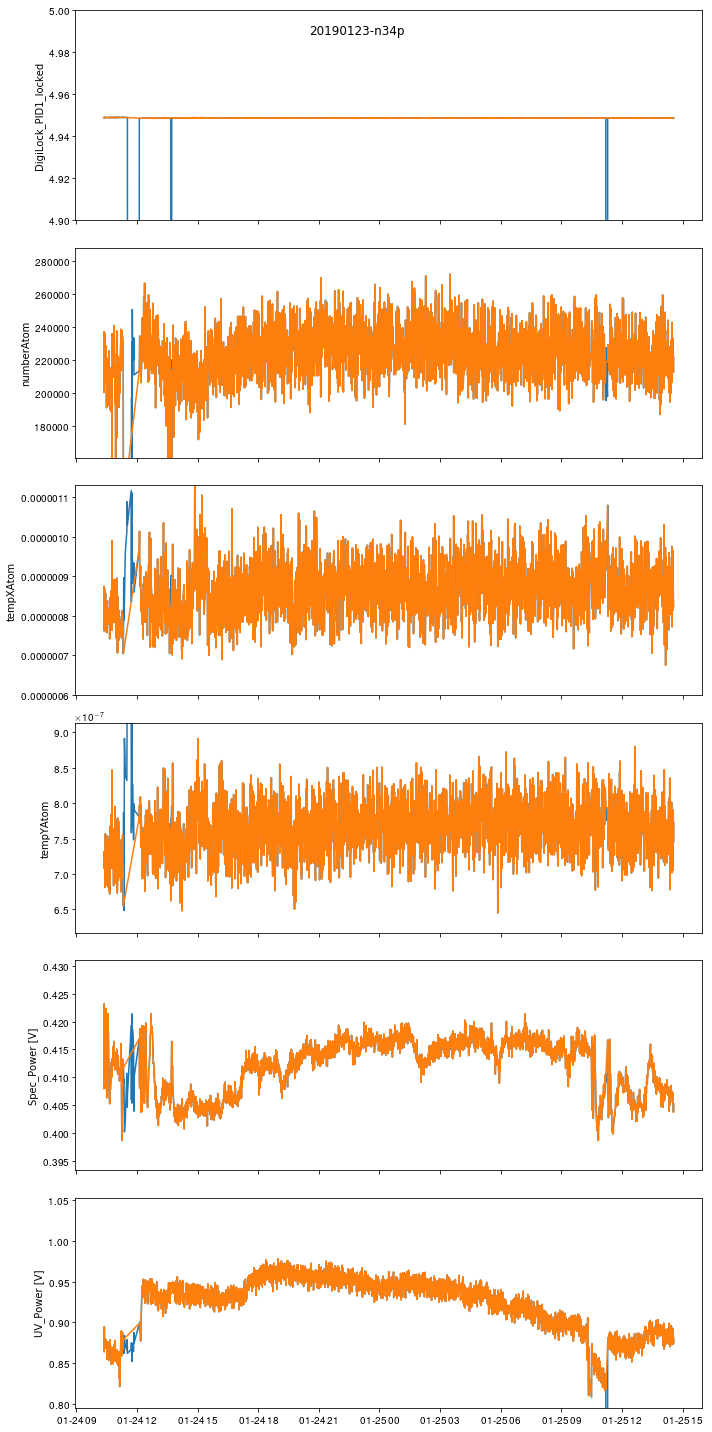

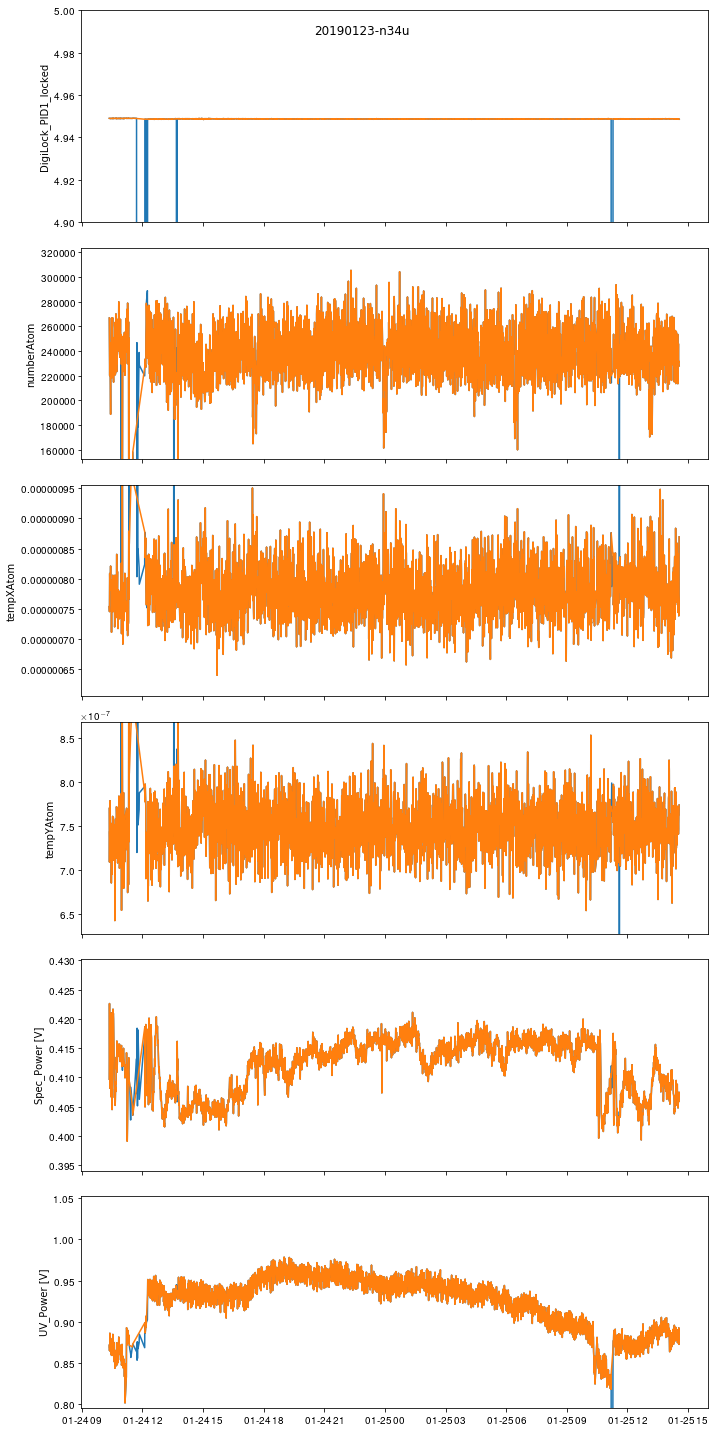

In [6]:
# First pass at removing bad data points
def reduce_data(df_data, name, show_plots):
    
    # Remove data where UV laser was not locked based on 'DigiLock_PID1_locked' column
    df_reduced = df_data[df_data['DigiLock_PID1_locked'] >= 4.9]
    
    # Remove data where atom number was above/below cutoff
    df_reduced = df_reduced[(100e3 <= df_reduced['numberAtom']) & (df_reduced['numberAtom'] <= 400e3)]
    
    # Remove data where tempYAtom was above/below cutoff
    df_reduced = df_reduced[(500E-9 <= df_reduced['tempYAtom']) & (df_reduced['tempYAtom'] <= 1.2E-6)]
    
    # Plotting original and reduced data sets
    df_orig = df_data.sort_values(by=['Timestamp'])
    df_redu = df_reduced.sort_values(by=['Timestamp'])
    
    if show_plots:
        [fig, ax]= plt.subplots(nrows=6, ncols=1, figsize=(10,20), sharex=True, sharey=False)
        fig.suptitle(name, usetex=False)

        ax[0].set_ylabel('DigiLock_PID1_locked', usetex=False)
        ax[0].plot(df_orig['Timestamp'], df_orig['DigiLock_PID1_locked'])
        ax[0].plot(df_redu['Timestamp'], df_redu['DigiLock_PID1_locked'])
        ax[0].set_ylim((4.9, 5))

        ax[1].set_ylabel('numberAtom', usetex=False)
        ax[1].plot(df_orig['Timestamp'], df_orig['numberAtom'])
        ax[1].plot(df_redu['Timestamp'], df_redu['numberAtom'])
        avg = np.mean(df_redu['numberAtom'])
        std = np.std(df_redu['numberAtom'])
        ax[1].set_ylim((avg-4*std, avg+4*std))

        ax[2].set_ylabel('tempXAtom', usetex=False)
        ax[2].plot(df_orig['Timestamp'], df_orig['tempXAtom'])
        ax[2].plot(df_redu['Timestamp'], df_redu['tempXAtom'])
        avg = np.mean(df_redu['tempXAtom'])
        std = np.std(df_redu['tempXAtom'])
        ax[2].set_ylim((avg-4*std, avg+4*std))

        ax[3].set_ylabel('tempYAtom', usetex=False)
        ax[3].plot(df_orig['Timestamp'], df_orig['tempYAtom'])
        ax[3].plot(df_redu['Timestamp'], df_redu['tempYAtom'])
        avg = np.mean(df_redu['tempYAtom'])
        std = np.std(df_redu['tempYAtom'])
        ax[3].set_ylim((avg-4*std, avg+4*std))

        ax[4].set_ylabel('Spec_Power [V]', usetex=False)
        ax[4].plot(df_orig['Timestamp'], df_orig['Spec_Power'])
        ax[4].plot(df_redu['Timestamp'], df_redu['Spec_Power'])
        avg = np.mean(df_redu['Spec_Power'])
        std = np.std(df_redu['Spec_Power'])
        ax[4].set_ylim((avg-4*std, avg+4*std))

        ax[5].set_ylabel('UV_Power [V]', usetex=False)
        ax[5].plot(df_orig['Timestamp'], df_orig['UV_Power'])
        ax[5].plot(df_redu['Timestamp'], df_redu['UV_Power'])
        avg = np.mean(df_redu['UV_Power'])
        std = np.std(df_redu['UV_Power'])
        ax[5].set_ylim((avg-4*std, avg+4*std))

        plt.tight_layout()
        plt.show()
    
    # Drop unused data columns
    df_reduced.drop(columns=['AI3', 'AI4', 'AI5', 'AI6', 'AI7'], inplace=True)
    
    return df_reduced

pol_reduced = reduce_data(pol_data, POL_NAME, True)
unpol_reduced = reduce_data(unpol_data, UNPOL_NAME, True)

### Aggregrate data

In [7]:
def aggregrate_data(df_data, indVar):
    df_grouped = df_data.groupby(by=indVar, as_index=False, sort=True)
    
    #df_out = df_grouped.agg([np.mean, np.std])
    df_out = df_grouped.agg({'sfiIntegral': [np.mean, np.std],
                             'UV_Power': [np.mean, np.std],
                             'Spec_Power': [np.mean, np.std],
                             'numberAtom': [np.mean, np.std],
                             'tempXAtom':  [np.mean, np.std],
                             'tempYAtom':  [np.mean, np.std],})
    
    df_out['count'] = df_grouped.size().values
    return df_out

indVar = ['imagevcoAtom']

pol_out = aggregrate_data(pol_reduced, indVar)
unpol_out = aggregrate_data(unpol_reduced, indVar)

### Adjust counts due to MCP saturation

In [8]:
# Using the MCP saturation curve taken on 2019/03/27 by varying the UV power, we can account for the non-linear detection.

def mcp_saturation(df):
    df_temp = df
    observed_counts = unumpy.uarray(df_temp['sfiIntegral','mean'], df_temp['sfiIntegral','std'])
    observed_counts = observed_counts/NUM_EXPOSURES
    
    corrected_counts = -SATURATION_A*unumpy.log(1-observed_counts/SATURATION_A)
    corrected_counts = NUM_EXPOSURES*corrected_counts
    
    df_temp['sfiIntegral_linearized','mean'] = unumpy.nominal_values(corrected_counts)
    df_temp['sfiIntegral_linearized', 'std'] = unumpy.std_devs(corrected_counts)
    
    return df_temp

pol_out = mcp_saturation(pol_out)
unpol_out = mcp_saturation(unpol_out)

### Calculate detunings

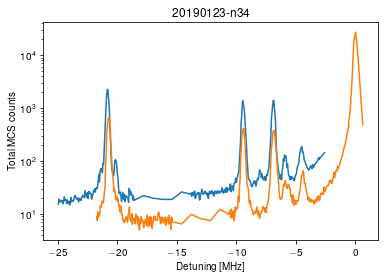

In [9]:
def calc_detuning(df, atomic, zeeman, order):
    df['detuning'] = order*2*(df['imagevcoAtom'] - (atomic + order*zeeman))
    
    return df

pol_out = calc_detuning(pol_out, ATOMIC, ZEEMAN, ORDER)
unpol_out = calc_detuning(unpol_out, ATOMIC, 0, ORDER)

plt.figure()
plt.plot(pol_out['detuning'], pol_out['sfiIntegral_linearized']['mean'])
plt.plot(unpol_out['detuning'], unpol_out['sfiIntegral_linearized']['mean'])
plt.yscale('log')
plt.title(SET_NAME)
plt.xlabel('Detuning [MHz]')
plt.ylabel('Total MCS counts')
plt.show()

## Analyzing the data

In [10]:
pol_data = pol_out
unpol_data = unpol_out

### Adjust counts based on 689 nm and UV intensities

In [11]:
def adjust_for_intensities(df):
    df_temp = df
    
    raw_sfiIntegral = unumpy.uarray(df_temp['sfiIntegral_linearized', 'mean'], df_temp['sfiIntegral_linearized', 'std'])
    raw_UV_Power = unumpy.uarray(df_temp['UV_Power', 'mean'], df_temp['UV_Power', 'std'])
    raw_Spec_Power = unumpy.uarray(df_temp['Spec_Power', 'mean'], df_temp['Spec_Power', 'std'])
    
    adjusted_sfiIntegral = raw_sfiIntegral/raw_UV_Power/raw_Spec_Power
    
    df_temp['sfiIntegral_adjusted', 'mean'] = unumpy.nominal_values(adjusted_sfiIntegral)
    df_temp['sfiIntegral_adjusted', 'std'] = unumpy.std_devs(adjusted_sfiIntegral)
    
    return df_temp

# Correcting for 320 nm and 689 nm intensities point-by-point

pol_data = adjust_for_intensities(pol_data)
unpol_data = adjust_for_intensities(unpol_data)

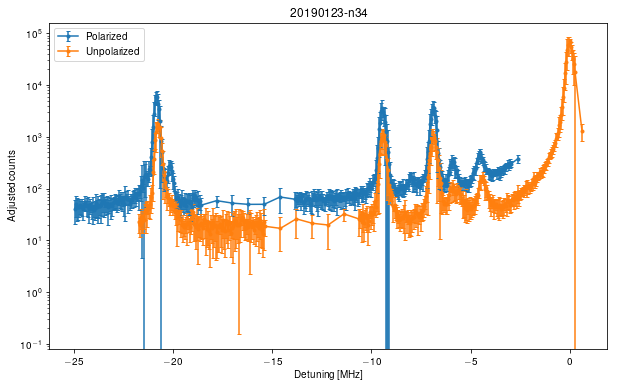

In [12]:
# Plotting results after adjusting for 320 nm and 689 nm powers

plt.figure(figsize=(10,6))
plt.errorbar(pol_data['detuning'], pol_data['sfiIntegral_adjusted', 'mean'], 
             yerr=pol_data['sfiIntegral_adjusted', 'std'],
             fmt='.-', capsize=2, label='Polarized')
plt.errorbar(unpol_data['detuning'], unpol_data['sfiIntegral_adjusted', 'mean'], 
             yerr=unpol_data['sfiIntegral_adjusted', 'std'],
             fmt='.-', capsize=2, label='Unpolarized')
plt.gca().set_yscale('log')
plt.title(SET_NAME)
plt.xlabel('Detuning [MHz]')
plt.ylabel('Adjusted counts')
plt.legend()
plt.show()

### Plots for DAMOP 2019

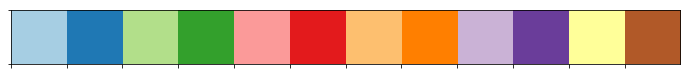

In [13]:
sns.palplot(sns.color_palette("Paired"))

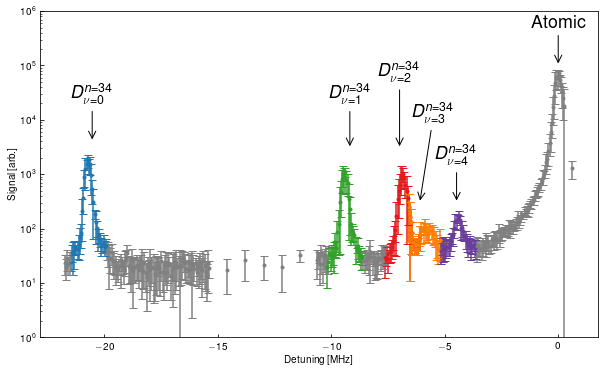

In [14]:
# Plot ranges and colors
D0_center_ex = -20.7206707 # Fitted position
D1_center_ex = -9.41763420 # Fitted position
D2_center_ex = -6.85418017 # Fitted position
D3_center_ex = -5.79142391 # Fitted position
D4_center_ex = -4.41051802 # Fitted position

D0_center_th = -20.533029820674397 # Theory position
D1_center_th = -9.1806880886635369 # Theory position
D2_center_th = -6.9896165107818060 # Theory position
D3_center_th = -6.1012672001143731 # Theory position
D4_center_th = -4.4783279344057858 # Theory position

width = 0.8
state = [[r'$\nu=0$', D0_center_ex-width, D0_center_ex+width, sns.color_palette("Paired")[1]],
         [r'$\nu=1$', D1_center_ex-width, D1_center_ex+width, sns.color_palette("Paired")[3]],
         [r'$\nu=2$', D2_center_ex-width, D2_center_ex+width, sns.color_palette("Paired")[5]],
         [r'$\nu=3$', D3_center_ex-width, D3_center_ex+width, sns.color_palette("Paired")[7]],
         [r'$\nu=4$', D4_center_ex-width, D4_center_ex+width, sns.color_palette("Paired")[9]]]

plt.figure(figsize=(10,6))
#plt.errorbar(pol_data['detuning'], pol_data['sfiIntegral_adjusted', 'mean'], 
#             yerr=pol_data['sfiIntegral_adjusted', 'std'],
#             fmt='.-', capsize=2, label='Polarized')

# Plot colored vibrational states
for i in state:
    i_label = i[0]
    i_lower = i[1]
    i_upper = i[2]
    i_color = i[3]
    i_xdata = unpol_data[(i_lower <= unpol_data['detuning']) & (unpol_data['detuning'] <= i_upper)]['detuning']
    i_ydata = unpol_data[(i_lower <= unpol_data['detuning']) & (unpol_data['detuning'] <= i_upper)]['sfiIntegral_adjusted', 'mean']
    i_yerr = unpol_data[(i_lower <= unpol_data['detuning']) & (unpol_data['detuning'] <= i_upper)]['sfiIntegral_adjusted', 'std']
    plt.errorbar(i_xdata, i_ydata, yerr=i_yerr, fmt='.', capsize=4, label=i_label, color=i_color)

# Plotting all the other data
r_xdata = unpol_data[~((state[0][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[0][2]))
                     &~((state[1][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[1][2]))
                     &~((state[2][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[2][2]))
                     &~((state[3][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[3][2]))
                     &~((state[4][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[4][2]))]['detuning']
r_ydata = unpol_data[~((state[0][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[0][2]))
                     &~((state[1][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[1][2]))
                     &~((state[2][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[2][2]))
                     &~((state[3][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[3][2]))
                     &~((state[4][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[4][2]))]['sfiIntegral_adjusted', 'mean']
r_yerr = unpol_data[~((state[0][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[0][2]))
                     &~((state[1][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[1][2]))
                     &~((state[2][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[2][2]))
                     &~((state[3][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[3][2]))
                     &~((state[4][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[4][2]))]['sfiIntegral_adjusted', 'std']

plt.errorbar(r_xdata, r_ydata, yerr=r_yerr, fmt='.', capsize=4, label=i_label, color='grey')

ax = plt.gca()

# Axis options
ax.set_yscale('log')
ax.set_ylim((1, 1E6))

# Tick options
ax.tick_params(which='both', axis='both', direction='in')

#plt.title(SET_NAME)

plt.xlabel('Detuning [MHz]')
plt.ylabel('Signal [arb.]')

#plt.legend(frameon=False)

# Text labels
text_kwargs = {'fontsize':18,
               'ha':'center'}

arrow_props = {'arrowstyle':'->'}

# Atomic line
xpos = 0
ypos = 1E5
plt.annotate(s=r'Atomic', xy=(xpos, ypos), xytext=(xpos, ypos*5), 
             arrowprops=arrow_props, **text_kwargs)

# D0
xpos = D0_center_th
ypos = 4E3
plt.annotate(s=r'$D_{\nu=0}^{n=34}$', xy=(xpos, ypos), xytext=(xpos, ypos*5), 
             arrowprops=arrow_props, **text_kwargs)

# D1
xpos = D1_center_th
ypos = 3E3
plt.annotate(s=r'$D_{\nu=1}^{n=34}$', xy=(xpos, ypos), xytext=(xpos, 2E4),
             arrowprops=arrow_props, **text_kwargs)

# D2
xpos = D2_center_th
ypos = 3E3
plt.annotate(s=r'$D_{\nu=2}^{n=34}$', xy=(xpos, ypos), xytext=(xpos, 5E4),
             arrowprops=arrow_props, **text_kwargs)

# D3
xpos = D3_center_th
ypos = 3E2
plt.annotate(s=r'$D_{\nu=3}^{n=34}$', xy=(xpos, ypos), xytext=(-5.5, 9E3),
             arrowprops=arrow_props, **text_kwargs)

# D4
xpos = D4_center_th
ypos = 3E2
plt.annotate(s=r'$D_{\nu=4}^{n=34}$', xy=(xpos, ypos), xytext=(xpos, ypos*5),
             arrowprops=arrow_props, **text_kwargs)

#plt.savefig('n34_unpolarized.png', bbox_inches='tight', transparent=False, dpi=1000)

plt.show()

# Read in data files

In [15]:
DIR = 'n34-potential_and_wave_functions'
potential = np.genfromtxt(os.path.join(DIR,'pot_87Sr_without_ion_atom_n34.txt'), skip_header=2)
nu0 = np.genfromtxt(os.path.join(DIR,'wvf_87Sr_without_ion_atom_n34-nu_0.txt'),skip_header=2)
nu1 = np.genfromtxt(os.path.join(DIR,'wvf_87Sr_without_ion_atom_n34-nu_1.txt'),skip_header=1)
nu2 = np.genfromtxt(os.path.join(DIR,'wvf_87Sr_without_ion_atom_n34-nu_2.txt'),skip_header=1)
nu3 = np.genfromtxt(os.path.join(DIR,'wvf_87Sr_without_ion_atom_n34-nu_3.txt'),skip_header=1)
nu4 = np.genfromtxt(os.path.join(DIR,'wvf_87Sr_without_ion_atom_n34-nu_4.txt'),skip_header=1)

potential = pd.DataFrame(potential, columns=['R','E'])
nu0 = pd.DataFrame(nu0, columns=['R', 'RPsi', 'E'])
nu1 = pd.DataFrame(nu1, columns=['R', 'RPsi', 'E'])
nu2 = pd.DataFrame(nu2, columns=['R', 'RPsi', 'E'])
nu3 = pd.DataFrame(nu3, columns=['R', 'RPsi', 'E'])
nu4 = pd.DataFrame(nu4, columns=['R', 'RPsi', 'E'])

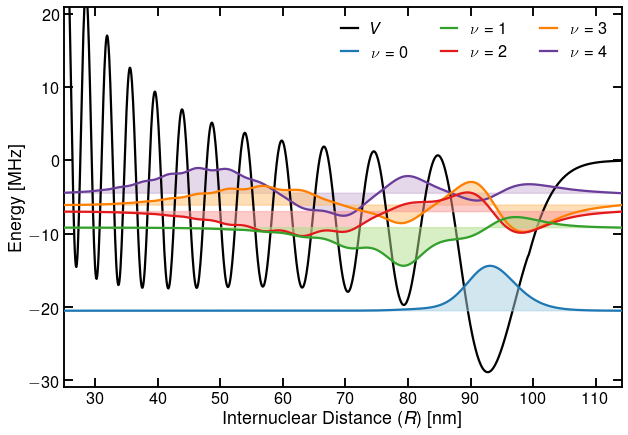

In [16]:
sns.set_context('talk')

# Arbitrary scaling of the wave functions heights
wvf_scale = 7E1

# [[DF, label, line color, fill_between color, alpha, scale factor, z order]]
nu_list = np.array([[nu0, r'$\nu=0$', sns.color_palette("Paired")[1], sns.color_palette("Paired")[0], 0.5, -1*wvf_scale, 5],
                    [nu1, r'$\nu=1$', sns.color_palette("Paired")[3], sns.color_palette("Paired")[2], 0.5, -1*wvf_scale, 4],
                    [nu2, r'$\nu=2$', sns.color_palette("Paired")[5], sns.color_palette("Paired")[4], 0.5, 1*wvf_scale, 3],
                    [nu3, r'$\nu=3$', sns.color_palette("Paired")[7], sns.color_palette("Paired")[6], 0.5, 1*wvf_scale, 2],
                    [nu4, r'$\nu=4$', sns.color_palette("Paired")[9], sns.color_palette("Paired")[8], 0.5, -1*wvf_scale, 1]])

fig = plt.figure(figsize=(10,7))
ax = plt.gca()

# Plotting the potential
#plt.plot(potential['R'], potential['E'], 'black', label='_nolegend_')
plt.plot(potential['R'], potential['E'], 'black', label=r'$V$')

for nu, label, line_color, fill_color, alpha, scale, z_order in nu_list:
    plt.plot(nu['R'], nu['RPsi']*scale + nu['E'], label=label, color=line_color, zorder=z_order+len(nu_list))
    plt.fill_between(nu['R'], nu['E'], nu['RPsi']*scale + nu['E'], color=fill_color, alpha=alpha, zorder=z_order)

plt.xlim(25, max(potential['R']))
plt.ylim(-31, 21)

# Axis options
ax.tick_params(axis='both', which='both', direction='in')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

# Label options
plt.ylabel(r'Energy [\si{\MHz}]')
plt.xlabel(r'Internuclear Distance ($R$) [\si{\nm}]')

# Legend options
plt.legend(ncol=3, handlelength=1, loc='upper right', frameon=False)

#plt.savefig('n34_wavefunctions.pdf', bbox_inches='tight', transparent=True)
#plt.savefig('n34_wavefunctions.eps', format='eps', bbox_inches='tight')
#plt.savefig('n34_wavefunctions.png', bbox_inches='tight', dpi=1000, transparent=False)

plt.show()

# Make combined wave function and data figure

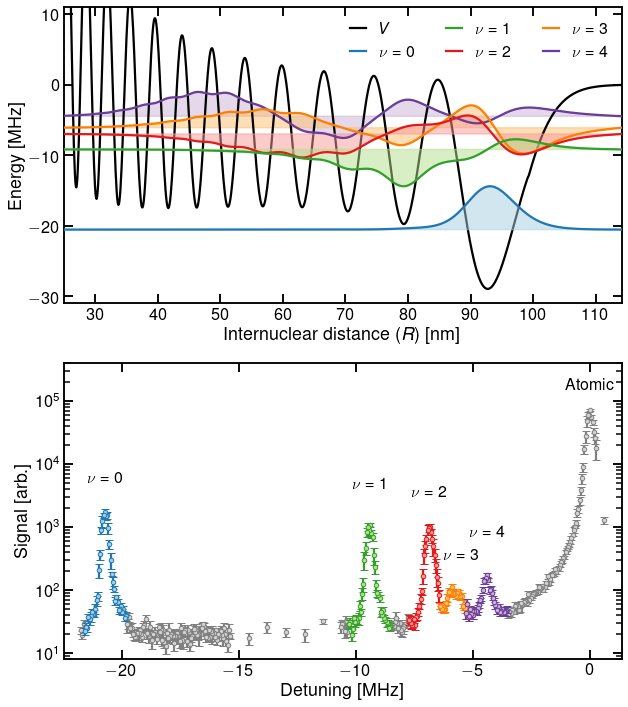

In [31]:
sns.set_context('talk')
[fig, axs] = plt.subplots(nrows=2, ncols=1, figsize=(10,12))

###########################################
# n=34 wave functions

# Arbitrary scaling of the wave functions heights
wvf_scale = 7E1

# [[DF, label, line color, fill_between color, alpha, scale factor, z order]]
nu_list = np.array([[nu0, r'$\nu=0$', sns.color_palette("Paired")[1], sns.color_palette("Paired")[0], 0.5, -1*wvf_scale, 5],
                    [nu1, r'$\nu=1$', sns.color_palette("Paired")[3], sns.color_palette("Paired")[2], 0.5, -1*wvf_scale, 4],
                    [nu2, r'$\nu=2$', sns.color_palette("Paired")[5], sns.color_palette("Paired")[4], 0.5, 1*wvf_scale, 3],
                    [nu3, r'$\nu=3$', sns.color_palette("Paired")[7], sns.color_palette("Paired")[6], 0.5, 1*wvf_scale, 2],
                    [nu4, r'$\nu=4$', sns.color_palette("Paired")[9], sns.color_palette("Paired")[8], 0.5, -1*wvf_scale, 1]])

# Plotting the potential
#plt.plot(potential['R'], potential['E'], 'black', label='_nolegend_')
axs[0].plot(potential['R'], potential['E'], 'black', label=r'$V$')

for nu, label, line_color, fill_color, alpha, scale, z_order in nu_list:
    axs[0].plot(nu['R'], nu['RPsi']*scale + nu['E'], label=label, color=line_color, zorder=z_order+len(nu_list))
    axs[0].fill_between(nu['R'], nu['E'], nu['RPsi']*scale + nu['E'], color=fill_color, alpha=alpha, zorder=z_order)

axs[0].set_xlim(25, max(potential['R']))
axs[0].set_ylim(-31, 11)

# Label options
axs[0].set_ylabel(r'Energy [\si{\MHz}]')
axs[0].set_xlabel(r'Internuclear distance ($R$) [\si{\nm}]')

# Legend options
axs[0].legend(ncol=3, handlelength=1, loc='upper right', frameon=False, fontsize=16)

###########################################
# n=34 (unpolarized) spectra plot

# Plot ranges and colors
D0_center_ex = -20.7206707 # Fitted position
D1_center_ex = -9.41763420 # Fitted position
D2_center_ex = -6.85418017 # Fitted position
D3_center_ex = -5.79142391 # Fitted position
D4_center_ex = -4.41051802 # Fitted position

D0_center_th = -20.533029820674397 # Theory position
D1_center_th = -9.1806880886635369 # Theory position
D2_center_th = -6.9896165107818060 # Theory position
D3_center_th = -6.1012672001143731 # Theory position
D4_center_th = -4.4783279344057858 # Theory position

width = 0.9

cp = sns.color_palette("Paired")

state = [[r'$\nu=0$', D0_center_ex-width, D0_center_ex+width, cp[1], cp[1-1]],
         [r'$\nu=1$', D1_center_ex-width, D1_center_ex+width, cp[3], cp[3-1]],
         [r'$\nu=2$', D2_center_ex-width, D2_center_ex+width*0.7, cp[5], cp[5-1]],
         [r'$\nu=3$', D3_center_ex-width*0.7, D3_center_ex+width, cp[7], cp[7-1]],
         [r'$\nu=4$', D4_center_ex-width, D4_center_ex+width, cp[9], cp[9-1]]]

# Plot colored vibrational states
for i in state:
    i_label = i[0]
    i_lower = i[1]
    i_upper = i[2]
    i_markeredgecolor = i[3]
    i_ecolor = i_markeredgecolor
    i_markerfacecolor = i[4]
    i_xdata = unpol_data[(i_lower <= unpol_data['detuning']) & (unpol_data['detuning'] <= i_upper)]['detuning']
    i_count = unpol_data[(i_lower <= unpol_data['detuning']) & (unpol_data['detuning'] <= i_upper)]['count']
    i_ydata = unpol_data[(i_lower <= unpol_data['detuning']) & (unpol_data['detuning'] <= i_upper)]['sfiIntegral_adjusted', 'mean']
    i_yerr = unpol_data[(i_lower <= unpol_data['detuning']) & (unpol_data['detuning'] <= i_upper)]['sfiIntegral_adjusted', 'std']
    
    # Divide signal by sqrt(number of points) to get standard error
    i_yerr = i_yerr/np.sqrt(i_count)
    
    axs[1].errorbar(i_xdata, i_ydata, yerr=i_yerr, fmt='.', capsize=4, label=i_label, zorder=2,
                    markeredgecolor=i_markeredgecolor, ecolor=i_ecolor, markerfacecolor=i_markerfacecolor)

# Plotting all the other data
r_xdata = unpol_data[~((state[0][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[0][2]))
                     &~((state[1][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[1][2]))
                     &~((state[2][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[2][2]))
                     &~((state[3][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[3][2]))
                     &~((state[4][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[4][2]))]['detuning']

r_count = unpol_data[~((state[0][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[0][2]))
                     &~((state[1][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[1][2]))
                     &~((state[2][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[2][2]))
                     &~((state[3][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[3][2]))
                     &~((state[4][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[4][2]))]['count']

r_ydata = unpol_data[~((state[0][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[0][2]))
                     &~((state[1][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[1][2]))
                     &~((state[2][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[2][2]))
                     &~((state[3][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[3][2]))
                     &~((state[4][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[4][2]))]['sfiIntegral_adjusted', 'mean']

r_yerr = unpol_data[~((state[0][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[0][2]))
                     &~((state[1][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[1][2]))
                     &~((state[2][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[2][2]))
                     &~((state[3][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[3][2]))
                     &~((state[4][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[4][2]))]['sfiIntegral_adjusted', 'std']

# Divide signal by sqrt(number of points) to get standard error
#r_ydata = r_ydata/np.sqrt(r_count)
r_yerr = r_yerr/np.sqrt(r_count)

axs[1].errorbar(r_xdata, r_ydata, yerr=r_yerr, fmt='.', capsize=4, label=i_label, zorder=1,
                markeredgecolor='grey', ecolor='grey', markerfacecolor='lightgrey')

# Axis options
axs[1].set_xlim((min(unpol_data['detuning'])-0.75,
                 max(unpol_data['detuning'])+0.75))
axs[1].set_yscale('log')
axs[1].set_ylim((8, 4E5))

#plt.title(SET_NAME)

axs[1].set_xlabel('Detuning [\si{\MHz}]')
axs[1].set_ylabel('Signal [arb.]')

#plt.legend(frameon=False)

# Text labels
text_kwargs = {'fontsize':16,
               'ha':'center'}

arrow_props = {'arrowstyle':'->'}

# Atomic line
xpos = 0
ypos = 3E4
axs[1].annotate(s=r'Atomic', xy=(xpos, ypos), xytext=(xpos, ypos*5), **text_kwargs)

# D0
#xpos = D0_center_th
xpos = D0_center_ex
ypos = 5E3
axs[1].annotate(s=r'$\nu=0$', xy=(xpos, ypos), xytext=(xpos, ypos), **text_kwargs)

# D1
#xpos = D1_center_th
xpos = D1_center_ex
ypos = 4E3
axs[1].annotate(s=r'$\nu=1$', xy=(xpos, ypos), xytext=(xpos, ypos), **text_kwargs)

# D2
#xpos = D2_center_th
xpos = D2_center_ex
ypos = 3E3
axs[1].annotate(s=r'$\nu=2$', xy=(xpos, ypos), xytext=(xpos, ypos), **text_kwargs)

# D3
#xpos = D3_center_th
xpos = D3_center_ex
ypos = 3E2
axs[1].annotate(s=r'$\nu=3$', xy=(xpos, ypos), xytext=(-5.5, ypos), **text_kwargs)

# D4
#xpos = D4_center_th
xpos = D4_center_ex
ypos = 7E2
axs[1].annotate(s=r'$\nu=4$', xy=(xpos, ypos), xytext=(xpos, ypos), **text_kwargs)


###########################################
# Figure options

# Axis options
for ax in axs:
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(which='both', axis='both', direction='in')

plt.savefig('n34-wave_functions_and_spectra.pdf', bbox_inches='tight', transparent=True)

plt.show()